In [1]:
from sklearn.datasets import make_circles

X, y = make_circles(n_samples=750, shuffle=True, random_state=42, noise=0.05, factor=0.3)

In [2]:
X[:10]

array([[-0.201213  ,  0.28808287],
       [ 0.92670161, -0.17007869],
       [-0.54141113,  0.77194143],
       [-0.44251885, -0.83976482],
       [ 0.30471255, -0.9159678 ],
       [ 0.11895822, -0.26454139],
       [ 0.83515802, -0.50530766],
       [-0.84280451,  0.49533718],
       [-0.35271995,  0.26198348],
       [ 0.27862207, -0.04298763]])

In [3]:
y[:10]

array([1, 0, 0, 0, 0, 1, 0, 0, 1, 1], dtype=int64)

(-2.0, 2.0)

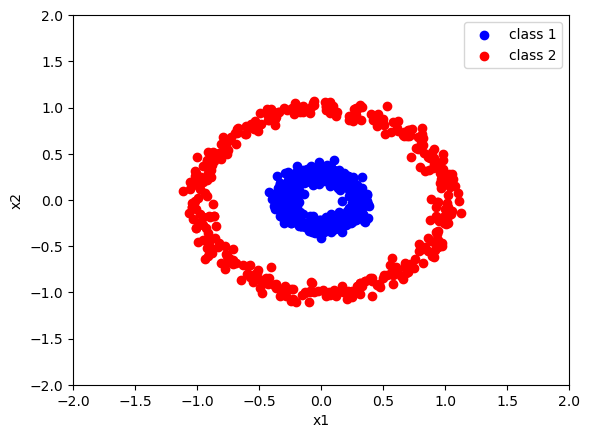

In [4]:
import matplotlib.pyplot as plt

plt.scatter(X[y==1, 0], X[y==1, 1], c='blue', label="class 1")
plt.scatter(X[y==0, 0], X[y==0, 1], c='red', label="class 2")
plt.legend(loc='upper right')
plt.xlabel('x1')
plt.ylabel('x2')
plt.xlim(-2, 2)
plt.ylim(-2, 2)

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [6]:
import time
import torch
from torch import nn
from torch.nn import BCELoss

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

net = nn.Sequential(nn.Linear(2, 10),
                    nn.ReLU(),
                    nn.Linear(10, 10),
                    nn.ReLU(),
                    nn.Linear(10, 1), #binary has ony one output
                    nn.Sigmoid()).to(device)

In [8]:
device

device(type='cuda')

In [9]:
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

batch_size = 4
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)

In [10]:
loss = BCELoss(reduction='mean')
lr = 0.01
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

In [11]:
epochs = 100
train_losses = []
test_losses = []
for epoch in range(epochs):
    start = time.time()
    for data, target in train_loader:
        optimizer.zero_grad()
        data = data.to(device)
        target = target.to(device).view(-1, 1)
        output = net(data)
        L = loss(output, target)
        L.backward()
        optimizer.step()

    y_train_pred_proba = net(X_train)
    training_loss = loss(y_train_pred_proba, y_train.view(-1, 1)).item()    
    y_test_pred_proba = net(X_test)
    test_loss = loss(y_test_pred_proba, y_test.view(-1, 1)).item()
    train_losses.append(training_loss)
    test_losses.append(test_loss)
    
    end = time.time()
    print("Epoch {}: Train_loss {}, Validation_loss {}, Seconds {}".format(epoch, training_loss, test_loss, end-start))

Epoch 0: Train_loss 0.26475781202316284, Validation_loss 0.2946927547454834, Seconds 1.2146713733673096
Epoch 1: Train_loss 0.022786380723118782, Validation_loss 0.026283632963895798, Seconds 0.21973371505737305
Epoch 2: Train_loss 0.006100559141486883, Validation_loss 0.007490182761102915, Seconds 0.21623563766479492
Epoch 3: Train_loss 0.0028132812585681677, Validation_loss 0.0036337003111839294, Seconds 0.20815706253051758
Epoch 4: Train_loss 0.0009378826944157481, Validation_loss 0.0014666946372017264, Seconds 0.2031090259552002
Epoch 5: Train_loss 0.0004522095259744674, Validation_loss 0.0007226243033073843, Seconds 0.2022874355316162
Epoch 6: Train_loss 0.00028410539380274713, Validation_loss 0.00047452052240259945, Seconds 0.21100282669067383
Epoch 7: Train_loss 0.00020232872338965535, Validation_loss 0.00035650067729875445, Seconds 0.20429611206054688
Epoch 8: Train_loss 0.00015306136629078537, Validation_loss 0.0002771791769191623, Seconds 0.20104742050170898
Epoch 9: Train_lo

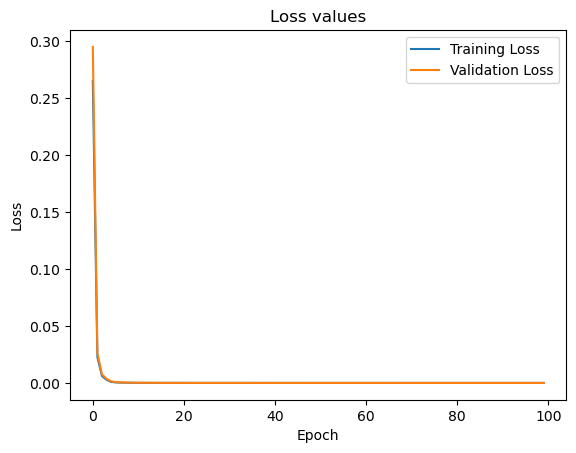

In [12]:
plt.plot(train_losses, label="Training Loss")
plt.plot(test_losses, label="Validation Loss")
plt.title("Loss values")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

In [13]:
y_test_pred_proba = net(X_test)
y_test_pred = (y_test_pred_proba.detach().cpu().numpy() >= 0.5).astype(int)

In [14]:
y_test = y_test.detach().cpu().numpy()

In [15]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        67
         1.0       1.00      1.00      1.00        83

    accuracy                           1.00       150
   macro avg       1.00      1.00      1.00       150
weighted avg       1.00      1.00      1.00       150



In [16]:
confusion_matrix(y_test, y_test_pred)

array([[67,  0],
       [ 0, 83]], dtype=int64)

Text(0.5, 1.0, 'Receiver Operating Characteristic - PyTorch')

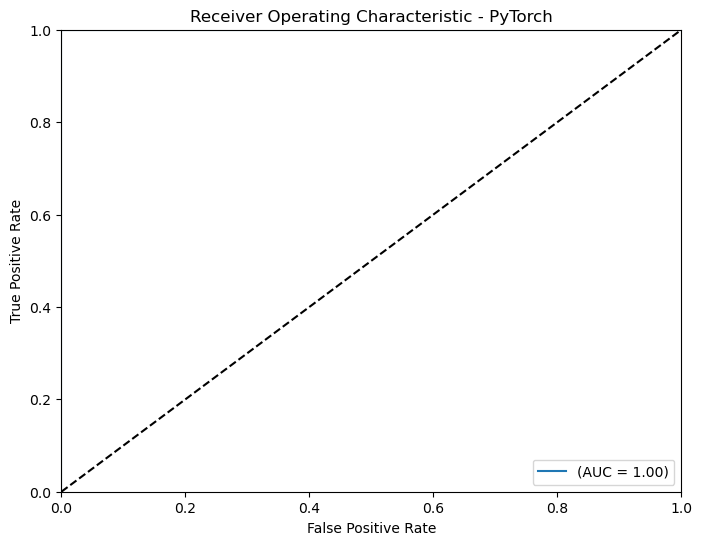

In [17]:
from sklearn.metrics import roc_curve, roc_auc_score

plt.figure(figsize=(8, 6))
fpr, tpr, _ = roc_curve(y_test, y_test_pred)
roc_auc = roc_auc_score(y_test, y_test_pred)
plt.plot(fpr, tpr, label=f'(AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.legend(loc='lower right')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - PyTorch')